# Environment Setup

### Source: PyTorch/Documentation

In [ ]:
%matplotlib inline

In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from PIL import Image
import shutil
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

torch.manual_seed(0)
random.seed(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)


PyTorch Version:  2.0.0+cu118
Torchvision Version:  0.15.1+cu118
cuda


# Configure Data and Experimental Settings

In [ ]:
# link to drive & use our dataset
import os
HOME = os.getcwd()
print(HOME)
from google.colab import drive
drive.mount('/content/drive')

/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/classi/data2'

In [ ]:
# # Top level data directory. Here we assume the format of the directory conforms 
# #   to the ImageFolder structure
# data_dir = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception, mobile, effic]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 25

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

# Train Model

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, save_path=None):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    if save_path is not None:
        torch.save(best_model_wts, save_path)
    
    return model, val_acc_history

In [ ]:
# Set/turn off configuration for feature extraction
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Model Initiation

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    #print('feature_extract:', feature_extract)
    #print('model_name:', model_name)
    #print('use_pretrained:', use_pretrained)
    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "effic":
        """ EfficientNet
        """
        model_ft = models.efficientnet_b0(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
        input_size = 224

    elif model_name == "mobile":
        """ MobileNet
        """
        model_ft = models.mobilenet_v2(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        #model_ft.fc=torch.nn.Linear(model_ft.fc.in_features, num_classes)
        model_ft.classifier[1] = torch.nn.Linear(in_features=model_ft.classifier[1].in_features, out_features=num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:06<00:00, 79.9MB/s]


# Training -- Load Data

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


Initializing Datasets and Dataloaders...


# Set Optimizer

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


# Define loss, set path to save the model, and start to train the model

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
 
# Train and evaluate
save_path = "/content/drive/MyDrive/classi/shared_results/SYH/vgg3.pt"

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"), save_path=save_path)

Epoch 0/24
----------
train Loss: 0.1843 Acc: 0.9254
val Loss: 0.1585 Acc: 0.9300

Epoch 1/24
----------
train Loss: 0.1595 Acc: 0.9352
val Loss: 0.1917 Acc: 0.9400

Epoch 2/24
----------
train Loss: 0.1598 Acc: 0.9324
val Loss: 0.2265 Acc: 0.9200

Epoch 3/24
----------
train Loss: 0.1474 Acc: 0.9338
val Loss: 0.2834 Acc: 0.9400

Epoch 4/24
----------
train Loss: 0.1872 Acc: 0.9169
val Loss: 0.3076 Acc: 0.9000

Epoch 5/24
----------
train Loss: 0.1658 Acc: 0.9324
val Loss: 0.2949 Acc: 0.9200

Epoch 6/24
----------
train Loss: 0.1715 Acc: 0.9127
val Loss: 0.2515 Acc: 0.9300

Epoch 7/24
----------
train Loss: 0.1314 Acc: 0.9493
val Loss: 0.3018 Acc: 0.9200

Epoch 8/24
----------
train Loss: 0.1619 Acc: 0.9352
val Loss: 0.1833 Acc: 0.9300

Epoch 9/24
----------
train Loss: 0.1659 Acc: 0.9197
val Loss: 0.3742 Acc: 0.9400

Epoch 10/24
----------
train Loss: 0.1491 Acc: 0.9380
val Loss: 0.2623 Acc: 0.9500

Epoch 11/24
----------
train Loss: 0.1477 Acc: 0.9366
val Loss: 0.2488 Acc: 0.9300

Ep

Comparison with Model Trained from Scratch
------------------------------------------

Just for fun, lets see how the model learns if we do not use transfer
learning. The performance of finetuning vs. feature extracting depends
largely on the dataset but in general both transfer learning methods
produce favorable results in terms of training time and overall accuracy
versus a model trained from scratch.




In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))


Epoch 0/24
----------
train Loss: 1.9006 Acc: 0.4704
val Loss: 1.7896 Acc: 0.4900

Epoch 1/24
----------
train Loss: 1.0505 Acc: 0.4803
val Loss: 0.8008 Acc: 0.5500

Epoch 2/24
----------
train Loss: 1.0034 Acc: 0.5085
val Loss: 0.7689 Acc: 0.4900

Epoch 3/24
----------
train Loss: 0.9215 Acc: 0.4549
val Loss: 0.8595 Acc: 0.4700

Epoch 4/24
----------
train Loss: 0.8978 Acc: 0.4718
val Loss: 0.8156 Acc: 0.5100

Epoch 5/24
----------
train Loss: 0.8110 Acc: 0.5352
val Loss: 0.7260 Acc: 0.5400

Epoch 6/24
----------
train Loss: 0.8203 Acc: 0.5310
val Loss: 0.7947 Acc: 0.4500

Epoch 7/24
----------
train Loss: 0.7641 Acc: 0.5000
val Loss: 0.6995 Acc: 0.5100

Epoch 8/24
----------
train Loss: 0.7598 Acc: 0.5225
val Loss: 0.7393 Acc: 0.4800

Epoch 9/24
----------
train Loss: 0.7405 Acc: 0.5113
val Loss: 0.7309 Acc: 0.4600

Epoch 10/24
----------
train Loss: 0.7494 Acc: 0.5127
val Loss: 0.7160 Acc: 0.4800

Epoch 11/24
----------
train Loss: 0.7193 Acc: 0.5268
val Loss: 0.7084 Acc: 0.5200

Ep

In [ ]:
# feature extraction
f_model,_ = initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True)
f_model = f_model.to(device)
f_optimizer = optim.SGD(f_model.parameters(), lr=0.001, momentum=0.9)
f_criterion = nn.CrossEntropyLoss()
_,f_hist = train_model(f_model, dataloaders_dict, f_criterion, f_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/24
----------
train Loss: 0.6855 Acc: 0.6070
val Loss: 0.5983 Acc: 0.7000

Epoch 1/24
----------
train Loss: 0.6973 Acc: 0.6296
val Loss: 0.6909 Acc: 0.6100

Epoch 2/24
----------
train Loss: 0.6340 Acc: 0.6732
val Loss: 0.5574 Acc: 0.7100

Epoch 3/24
----------
train Loss: 0.6537 Acc: 0.6535
val Loss: 0.5259 Acc: 0.7400

Epoch 4/24
----------
train Loss: 0.6435 Acc: 0.6423
val Loss: 0.5392 Acc: 0.6700

Epoch 5/24
----------
train Loss: 0.6849 Acc: 0.6479
val Loss: 0.5424 Acc: 0.7400

Epoch 6/24
----------
train Loss: 0.6479 Acc: 0.6746
val Loss: 0.6002 Acc: 0.7100

Epoch 7/24
----------
train Loss: 0.7079 Acc: 0.6577
val Loss: 0.5456 Acc: 0.7100

Epoch 8/24
----------
train Loss: 0.6832 Acc: 0.6648
val Loss: 0.5727 Acc: 0.6900

Epoch 9/24
----------
train Loss: 0.6653 Acc: 0.6704
val Loss: 0.5471 Acc: 0.7200

Epoch 10/24
----------
train Loss: 0.6820 Acc: 0.6648
val Loss: 0.5410 Acc: 0.7000

Epoch 11/24
----------
train Loss: 0.6354 Acc: 0.6789
val Loss: 0.5491 Acc: 0.7200

Ep

In [ ]:
# Plot the performance of the three methods: 1) Train from scratch, 2) feature extraction, and 3) fine-tuning
ohist = []
shist = []
fhist = []
ohist = [h.cpu().numpy()*100 for h in hist]
shist = [h.cpu().numpy()*100 for h in scratch_hist]
fhist = [h.cpu().numpy()*100 for h in f_hist]

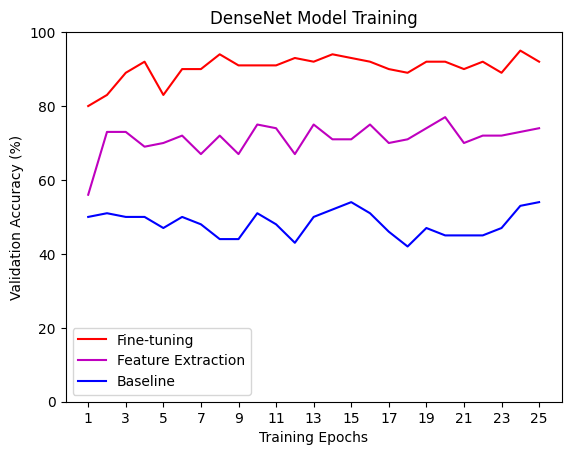

In [ ]:
plt.title("DenseNet Model Training")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.plot(range(1,num_epochs+1),ohist,label="Fine-tuning",color="r")
plt.plot(range(1,num_epochs+1),fhist,label="Feature Extraction",color="m")
plt.plot(range(1,num_epochs+1),shist,label="Baseline",color="b")
plt.ylim((0,100.))
plt.xticks(np.arange(1, num_epochs+1, 2.0))
plt.legend()
plt.show()